In [12]:
import random
import scipy
import textwrap
import time
import itertools
import logomaker
import copy
import re
from tqdm import tqdm
import os
from Bio.Data import CodonTable
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio  import SeqIO
import numpy as np
import pandas as pd
import math
import pickle
import dnds
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy import stats
import sys
from scipy.special import comb
from scipy.spatial.distance import squareform
sys.path.append("../src/seq_space_lib/")
import sequence_space_lib as seqsp

sys.path.append("../src/simulate_prot_evol_lib/")
import simulate_prot_evol_lib as simevol

from ete3 import Tree, TreeStyle, TextFace, add_face_to_node

path='../data/small_simulations/'

# Expected dimensionality as a function of the fraction of allowed amino acid states

Figure 1B

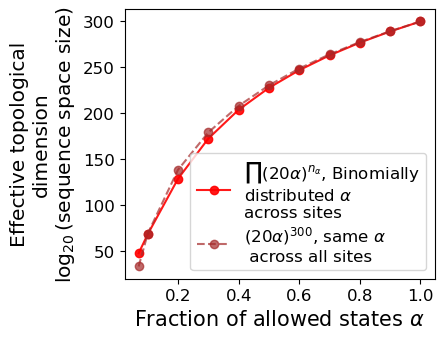

In [21]:
#in log_20 

fig, ax=plt.subplots(figsize=(4, 3.5))

seqlen=300
fs1=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

ax.set_ylabel('Effective topological\ndimension\n'+r'$\log_{20}$(sequence space size)', fontsize=14.5)
ax.set_xlabel(r'Fraction of allowed states $\alpha$', fontsize=15)

ax.plot([0.07]+fs1, [seqsp.truncated_binomial_log_product_base20(seqlen, p, 20, base=20) for p in [0.07]+fs1], 
            label=r'$\prod (20\alpha)^{n_{\alpha}}$, Binomially'+'\n'+r'distributed $\alpha$'+'\nacross sites', 
            alpha=0.9, c='red', 
            marker='o', )
ax.plot([0.07]+fs1, 300*np.log(np.array([0.07]+fs1)*20)/np.log(20),  '--' , alpha=0.7,  c='brown', 
         marker='o', label=r'$(20\alpha)^{300}$, same $\alpha$'+'\n across all sites')
ax.legend(fontsize=12, labelspacing=0.25)
ax.tick_params(axis='both', which='major', labelsize=12)


# Compare random fit sequences with evolved ones

Figure 5B

## Generate data

In [ ]:
win_size_perc=0.5
repl=10
seqlen=300
nseq=1000

### 10 values of alpha: [0.07,0.6]

In [ ]:
fs=sorted(np.linspace(0.07, 0.6, repl).round(5))

In [ ]:
# tree
dimstats_tree1000=[]
for i, f in tqdm(enumerate(fs)): 
    for k in range(10):
        matrix=simevol.generate_matrix_AA(seqlen, fraction=f)
        randseq=simevol.generate_nt_seq(seqlen*3, 1, seqfrom='matrix', matrix=matrix)
        simtree = simevol.simulate_tree_with_depth_scaled_branch_lengths(nseq)
        leaves, nonsyn_subs, syn_subs, subs_attempts, tree, statslist = simevol.evolve_tree(randseq, matrix, simtree,
                                                                                        neighbors={}, limit_on='all_subs', gamma=0, 
                                                                                        equal_f_split=True, universal_neighbors=True)
        seqsaa=[str(Seq(s).translate()) for s in leaves]
        dists=simevol.get_distance_array(seqsaa)
        col_alpha_size, n_invar_sites, allaapersite=simevol.get_usage_aa_per_site(seqsaa, alphabet='aa', colfreqs_out=False)
        dimres=list(seqsp.max_k(dists, win_size_perc=win_size_perc, numbins=20, plot = False,  reg_range_from_data=True, flat=True, ci_r2_out_flat=True))
        dimres.append(seqlen-n_invar_sites)
        dimres.append(np.mean(col_alpha_size))
        dimres.append(np.max(dists))
        dimres.append(np.mean(dists))
        dimres.append(np.std(dists))
        dimstats_tree1000.append(dimres)

df_tree1000_reps=pd.DataFrame(dimstats_tree1000, columns=['dim', 'dim_r^2', 'dim_ci','num_var_sites', 'mean_alpha', 'max_dist', 'mean_dist', 'std_dist'])
df_tree1000_reps['mode']=['tree']*repl*10

10it [00:42,  4.24s/it]


In [ ]:
# notree
dimstats_star1000=[]
for i, f in tqdm(enumerate(fs)): 
    for k in range(10):
        matrix=simevol.generate_matrix_AA(seqlen, fraction=f)
        randseq=simevol.generate_nt_seq(seqlen*3, 1, seqfrom='matrix', matrix=matrix)
        simtree = simevol.simulate_tree_with_depth_scaled_branch_lengths(nseq, starlike=True)
        leaves, nonsyn_subs, syn_subs, subs_attempts, tree, statslist = simevol.evolve_tree(randseq, matrix, simtree,
                                                                                        neighbors={}, limit_on='all_subs', gamma=0, 
                                                                                        equal_f_split=True, universal_neighbors=True)
        seqsaa=[str(Seq(s).translate()) for s in leaves]
        dists=simevol.get_distance_array(seqsaa)
        col_alpha_size, n_invar_sites, allaapersite=simevol.get_usage_aa_per_site(seqsaa, alphabet='aa', colfreqs_out=False)
        dimres=list(seqsp.max_k(dists, win_size_perc=win_size_perc, numbins=20, plot = False,  reg_range_from_data=True, flat=True, ci_r2_out_flat=True))
        dimres.append(seqlen-n_invar_sites)
        dimres.append(np.mean(col_alpha_size))
        dimres.append(np.max(dists))
        dimres.append(np.mean(dists))
        dimres.append(np.std(dists))
        dimstats_star1000.append(dimres)

df_star1000_reps=pd.DataFrame(dimstats_star1000, columns=['dim', 'dim_r^2', 'dim_ci','num_var_sites', 'mean_alpha', 'max_dist', 'mean_dist', 'std_dist'])
df_star1000_reps['mode']=['starlike']*repl*10

10it [01:12,  7.26s/it]


In [ ]:
# random seqs 
dimstats_rand1000_reps_aa=[]
for i, f in tqdm(enumerate(fs)):   
    for k in range(10):
        matrix=simevol.generate_matrix_AA(seqlen, fraction=f)
        seqs=simevol.generate_nt_seq(seqlen*3, nseq, seqfrom='matrix', matrix=matrix, select_from='aa')
        seqsaa=[str(Seq(s).translate()) for s in seqs]
        dists=simevol.get_distance_array(seqsaa)
        col_alpha_size, n_invar_sites, allaapersite=simevol.get_usage_aa_per_site(seqsaa, alphabet='aa', colfreqs_out=False)
        dimres=list(seqsp.max_k(dists, win_size_perc=win_size_perc, numbins=20, plot = False,  reg_range_from_data=True, flat=True, ci_r2_out_flat=True))
        dimres.append(seqlen-n_invar_sites)
        dimres.append(np.mean(col_alpha_size))
        dimres.append(np.max(dists))
        dimres.append(np.mean(dists))
        dimres.append(np.std(dists))
        dimstats_rand1000_reps_aa.append(dimres)
df_rand1000_reps_aa=pd.DataFrame(dimstats_rand1000_reps_aa, columns=['dim', 'dim_r^2', 'dim_ci','num_var_sites', 'mean_alpha', 'max_dist', 'mean_dist', 'std_dist'])
df_rand1000_reps_aa['mode']=['random_aa']*repl*10

10it [04:17, 25.78s/it]


In [ ]:
dfall1000reps10=pd.concat([df_rand1000_reps_aa,  df_star1000_reps, df_tree1000_reps])
dfall1000reps10['F']=sorted(list(fs)*10)*3
dfall1000reps10['n_seq_from_dim_log10']=dfall1000reps10['dim']*np.log10((seqlen*dfall1000reps10['max_dist']))
dfall1000reps10['n_seq_from_dim_log20'] = dfall1000reps10['n_seq_from_dim_log10'] / np.log10(20)

#add confidence intervals
x = np.log10(seqlen * dfall1000reps10['max_dist'])  # log10(R/ε)

# Confidence intervals for dim
dfall1000reps10['log10_nseq_ci'] = dfall1000reps10['dim_ci'] * x

# Optional: in base 20
log_base = np.log10(20)
dfall1000reps10['log20_nseq_ci'] = dfall1000reps10['log10_nseq_ci'] / log_base

In [ ]:
dfall1000reps10.to_csv(path+'simu_compare_random_trees_F0.07-0.6_rep10_nseq1000.csv', index=False)

### 10 values of alpha: [0.1,1]

In [ ]:
fs1=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [ ]:
# tree
diststree1000=[]
dimstats_tree1000=[]
for i, f in tqdm(enumerate(fs1)): 
    for k in range(10):
        matrix=simevol.generate_matrix_AA(seqlen, fraction=f)
        randseq=simevol.generate_nt_seq(seqlen*3, 1, seqfrom='matrix', matrix=matrix)
        simtree = simevol.simulate_tree_with_depth_scaled_branch_lengths(nseq)
        leaves, nonsyn_subs, syn_subs, subs_attempts, tree, statslist = simevol.evolve_tree(randseq, matrix, simtree,
                                                                                        neighbors={}, limit_on='all_subs', gamma=0, 
                                                                                        equal_f_split=True, universal_neighbors=True)
        seqsaa=[str(Seq(s).translate()) for s in leaves]
        dists=simevol.get_distance_array(seqsaa)
        col_alpha_size, n_invar_sites, allaapersite=simevol.get_usage_aa_per_site(seqsaa, alphabet='aa', colfreqs_out=False)
        dimres=list(seqsp.max_k(dists, win_size_perc=win_size_perc, numbins=20, plot = False,  reg_range_from_data=True, flat=True, ci_r2_out_flat=True))
        dimres.append(seqlen-n_invar_sites)
        dimres.append(np.mean(col_alpha_size))
        dimres.append(np.max(dists))
        dimres.append(np.mean(dists))
        dimres.append(np.std(dists))
        dimstats_tree1000.append(dimres)

df_tree1000_reps1=pd.DataFrame(dimstats_tree1000, columns=['dim', 'dim_r^2', 'dim_ci','num_var_sites', 'mean_alpha', 'max_dist', 'mean_dist', 'std_dist'])
df_tree1000_reps1['mode']=['tree']*repl*10

10it [00:37,  3.80s/it]


In [ ]:
# notree
dimstats_star1000=[]
for i, f in tqdm(enumerate(fs1)): 
    for k in range(10):
        matrix=simevol.generate_matrix_AA(seqlen, fraction=f)
        randseq=simevol.generate_nt_seq(seqlen*3, 1, seqfrom='matrix', matrix=matrix)
        simtree = simevol.simulate_tree_with_depth_scaled_branch_lengths(nseq, starlike=True)
        leaves, nonsyn_subs, syn_subs, subs_attempts, tree, statslist = simevol.evolve_tree(randseq, matrix, simtree,
                                                                                        neighbors={}, limit_on='all_subs', gamma=0, 
                                                                                        equal_f_split=True, universal_neighbors=True)
        seqsaa=[str(Seq(s).translate()) for s in leaves]
        dists=simevol.get_distance_array(seqsaa)
        col_alpha_size, n_invar_sites, allaapersite=simevol.get_usage_aa_per_site(seqsaa, alphabet='aa', colfreqs_out=False)
        dimres=list(seqsp.max_k(dists, win_size_perc=win_size_perc, numbins=20, plot = False,  reg_range_from_data=True, flat=True, ci_r2_out_flat=True))
        dimres.append(seqlen-n_invar_sites)
        dimres.append(np.mean(col_alpha_size))
        dimres.append(np.max(dists))
        dimres.append(np.mean(dists))
        dimres.append(np.std(dists))
        dimstats_star1000.append(dimres)

df_star1000_reps1=pd.DataFrame(dimstats_star1000, columns=['dim', 'dim_r^2', 'dim_ci','num_var_sites', 'mean_alpha', 'max_dist', 'mean_dist', 'std_dist'])
df_star1000_reps1['mode']=['starlike']*repl*10

10it [00:53,  5.36s/it]


In [ ]:
# random seqs
dimstats_rand1000_reps_aa=[]
for i, f in tqdm(enumerate(fs1)):   
    for k in range(10):
        matrix=simevol.generate_matrix_AA(seqlen, fraction=f)
        seqs=simevol.generate_nt_seq(seqlen*3, nseq, seqfrom='matrix', matrix=matrix, select_from='aa')
        seqsaa=[str(Seq(s).translate()) for s in seqs]
        dists=simevol.get_distance_array(seqsaa)
        col_alpha_size, n_invar_sites, allaapersite=simevol.get_usage_aa_per_site(seqsaa, alphabet='aa', colfreqs_out=False)
        dimres=list(seqsp.max_k(dists, win_size_perc=win_size_perc, numbins=20, plot = False,  reg_range_from_data=True, flat=True, ci_r2_out_flat=True))
        dimres.append(seqlen-n_invar_sites)
        dimres.append(np.mean(col_alpha_size))
        dimres.append(np.max(dists))
        dimres.append(np.mean(dists))
        dimres.append(np.std(dists))
        dimstats_rand1000_reps_aa.append(dimres)
df_rand1000_reps_aa1=pd.DataFrame(dimstats_rand1000_reps_aa, columns=['dim', 'dim_r^2', 'dim_ci','num_var_sites', 'mean_alpha', 'max_dist', 'mean_dist', 'std_dist'])
df_rand1000_reps_aa1['mode']=['random_aa']*repl*10

10it [22:48, 136.90s/it]


In [ ]:
dfall1000reps101=pd.concat([df_rand1000_reps_aa1,  df_star1000_reps1, df_tree1000_reps1])
dfall1000reps101['F']=sorted(fs1*10)*3
dfall1000reps101['n_seq_from_dim_log10']=dfall1000reps101['dim']*np.log10((seqlen*dfall1000reps101['max_dist']))
dfall1000reps101['n_seq_from_dim_log20'] = dfall1000reps101['n_seq_from_dim_log10'] / np.log10(20)
#add confidence intervals
x = np.log10(seqlen * dfall1000reps101['max_dist'])  # log10(R/ε)

# Confidence intervals for dim
dfall1000reps101['log10_nseq_ci'] = dfall1000reps101['dim_ci'] * x

# Optional: in base 20
log_base = np.log10(20)
dfall1000reps101['log20_nseq_ci'] = dfall1000reps101['log10_nseq_ci'] / log_base

In [ ]:
dfall1000reps101.to_csv(path+'simu_compare_random_trees_F0.1-1_rep10_nseq1000.csv', index=False)

## Plot - Figure 5B

In [4]:
fs1=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
dfall1000reps10=pd.read_csv(path+'simu_compare_random_trees_F0.07-0.6_rep10_nseq1000.csv')
dfall1000reps101=pd.read_csv(path+'simu_compare_random_trees_F0.1-1_rep10_nseq1000.csv')
dffinal=pd.concat([dfall1000reps10[dfall1000reps10['F']==0.07],dfall1000reps101])

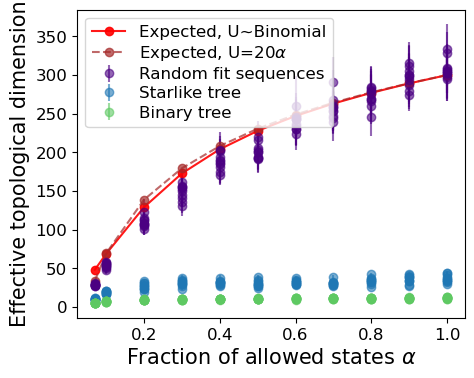

In [20]:
#in log_20 with tree and nontree

fig, ax=plt.subplots(figsize=(5, 4))

for i, label, color in zip(['random_aa', 
                     'starlike', 'tree'], ['Random fit sequences', 
                                           'Starlike tree', 'Binary tree'], ['indigo', 'tab:blue', '#5ec962']):
    df=dffinal[dffinal['mode']==i]
    ax.errorbar(df['F'],
                 df['n_seq_from_dim_log20'],
                 yerr=df['log20_nseq_ci'],
                 fmt='o',
                 alpha=0.6,
                 color=color,
                 label=label, #c='indigo', 
                 #markeredgecolor='k', markeredgewidth=0.1,
                 )

seqlen=300

ax.set_ylabel('Effective topological dimension', fontsize=15)
ax.set_xlabel(r'Fraction of allowed states $\alpha$', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.plot([0.07]+fs1, [seqsp.truncated_binomial_log_product_base20(seqlen, p, 20, base=20) for p in [0.07]+fs1], 
            label='Expected, U~Binomial', 
            alpha=0.9, c='red', 
            marker='o', )
ax.plot([0.07]+fs1, 300*np.log(np.array([0.07]+fs1)*20)/np.log(20),  '--' , alpha=0.7,  c='brown', 
         marker='o', label=r'Expected, U=20$\alpha$')
ax.legend(fontsize=12, labelspacing=0.25)



# Compare derived vs ancestral vs convergent states in sequences from tree and randomly generated

Figure 6A

In [24]:
from Bio.Seq import Seq
import logomaker
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
all_aa=['E', 'Q', 'R', 'F', 'N', 'A', 'V', 'D', 'Y', 'S', 'I', 'M', 'G', 'W', 'H', 'K', 'P', 'C', 'T', 'L']
aaa_to_ind_dict=dict(zip(all_aa, range(20)))

In [28]:
#generate common fitness matrix 
matrix_logo03=simevol.generate_matrix_AA(300, fraction=0.3)

## Generate data

### Random fit sequences 

In [29]:

matrix_logo03np=[]
for i in all_aa:
    matrix_logo03np.append(matrix_logo03[i])
matrix_logo03np=np.array(matrix_logo03np)
matrix_logo03np

array([[0, 1, 1, ..., 0, 1, 0],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 1, 1]], shape=(20, 300))

In [30]:
#random seq
delta=0.001
logo03=np.zeros(shape=np.shape(matrix_logo03np.T))[:50]
for site in range(len(logo03)):
    # Get indices where the value is exactly 1
    one_indices = np.where(matrix_logo03np.T[site] == 1)[0]
    sitetochange = np.random.choice(one_indices)
    logo03[site][sitetochange] = 1/2+delta
for site in range(len(logo03)):
    # Get indices where the value is exactly 1
    one_indices = np.where(matrix_logo03np.T[site] == 1)[0]
    sitetochange = np.random.choice(one_indices)
    logo03[site][sitetochange] =logo03[site][sitetochange] +1/2-delta

### Sequences from a starlike tree

In [32]:
random_sequence = simevol.generate_nt_seq(900, 1, seqfrom='matrix', matrix=matrix_logo03)
simtree = simevol.simulate_tree_with_depth_scaled_branch_lengths(300)
leaves, nonsyn_subs, syn_subs, subs_attempts, tree, statslist = simevol.evolve_tree(random_sequence, matrix_logo03, simtree,
                                                                                neighbors={}, limit_on='all_subs', gamma=0, 
                                                    
                                                                                equal_f_split=True, universal_neighbors=True)

In [33]:
inda=np.random.randint(0,300)
indb=np.random.randint(0,300)
treeseq03=[]
for i in [random_sequence, leaves[inda], leaves[indb], tree.get_common_ancestor(str(inda), str(indb)).sequence]:
    treeseq03.append(str(Seq(i).translate())[:50])
treeseq03

['MSNVSCKPWFNCEWVRGTYDCTGMNHHGINQMHQQDMQIRNFGHKIKKWE',
 'ITNGSCIPTFNWECPRGTYDCAGLSHQGSNKNRQQYILARKFGNRNKKGE',
 'KTSVSCKPWFSCEYVRGPYDCAGINSHGISKIHQQDIVIRRFAHEIKIWE',
 'MSNVSCKPWFNCEWVRGTYDCTGMNHHGINQMHQQDMQIRNFGHKIKKWE']

In [34]:
logo03tree=np.zeros(shape=np.shape(ntree.subs_matrix.T))[:50]
delta=0.001
for site in range(len(logo03tree)):
    logo03tree[site][aaa_to_ind_dict[treeseq03[1][site]]] = logo03tree[site][aaa_to_ind_dict[treeseq03[1][site]]]+1/2+delta
for site in range(len(logo03tree)):
    logo03tree[site][aaa_to_ind_dict[treeseq03[2][site]]] =logo03tree[site][aaa_to_ind_dict[treeseq03[2][site]]]+1/2-delta


## Plot - Figure 6A

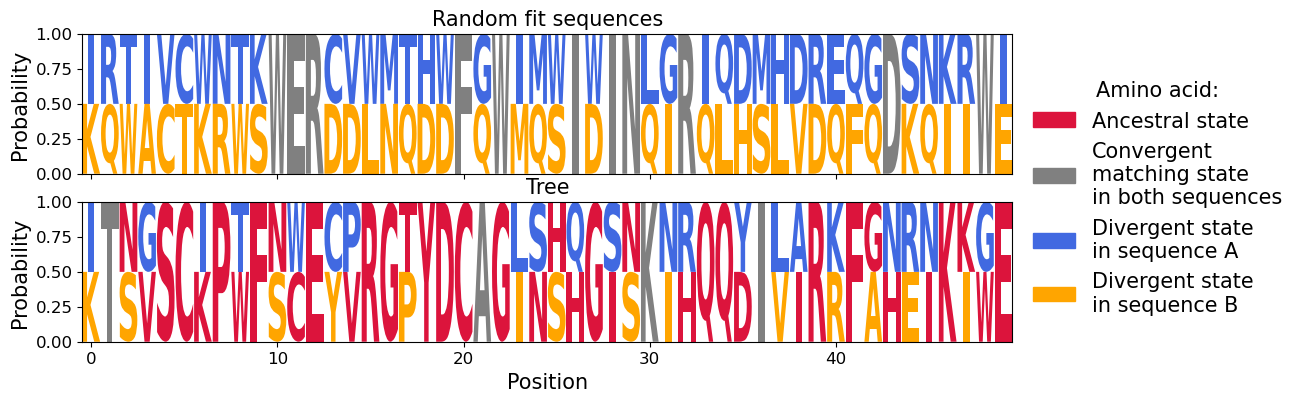

In [67]:
fig, ax=plt.subplots(2,1, figsize=(12,4), sharex=True, sharey=True)
# Build the PPM as a DataFrame
ppm = pd.DataFrame(logo03, columns=all_aa)
ppm.index.name = 'position'

# Create the logo
logo = logomaker.Logo(ppm, ax=ax[0])


# Step 3: Assign colors based on probabilities
for i, row in ppm.iterrows():
    # Get nonzero letters at this position
    nonzero = row[row > 0]
    
    if len(nonzero) == 1:
        # One letter: red
        letter = nonzero.index[0]
        logo.style_single_glyph(i, letter, color='grey')
    
    elif len(nonzero) == 2:
        # Two letters: top = orange, bottom = purple based on frequency
        sorted_letters = nonzero.sort_values(ascending=False).index.tolist()
        logo.style_single_glyph(i, sorted_letters[0], color='royalblue')
        logo.style_single_glyph(i, sorted_letters[1], color='orange')
        # Label and show
plt.title("Random seqeunces")
plt.xlabel("Position")
plt.ylabel("Probability")


# Define the ancestor at each position
dominant_letters = list(treeseq03[0])
lca_letters = list(treeseq03[3])
leaf1_letters=list(treeseq03[1])
positions = len(dominant_letters)


# Build the PPM as a DataFrame
ppm = pd.DataFrame(logo03tree, columns=all_aa)
ppm.index.name = 'position'

# Create the logo
logo = logomaker.Logo(ppm, ax=ax[1])

# Define custom colors
dominant_colors = 'crimson'
default_color = 'gray'

# Color each letter at each position
for i, (dom_letter, leafletter) in enumerate(zip(dominant_letters, leaf1_letters)):
    for letter in all_aa:
        if letter == dom_letter or letter==lca_letters[i]:
            color = dominant_colors 
        elif letter!=lca_letters[i] and np.isclose(ppm.loc[i][letter],1):
            color = 'grey'
        elif letter==leafletter:
            color = 'royalblue' 
        else:
            color = 'orange'
        logo.style_single_glyph(i, letter, color=color)

# Label and show
ax[0].set_title("Random fit sequences", size=15)
ax[0].set_ylabel("Probability", size=15)
ax[1].set_title("Tree", size=15)
ax[1].set_xlabel("Position", size=15)
ax[1].set_ylabel("Probability", size=15)

# Create legend handles
legend_handles = [
    mpatches.Patch(color='crimson', label='Ancestral state'),
    mpatches.Patch(color='grey', label='Convergent\nmatching state\nin both sequences'),
    mpatches.Patch(color='royalblue', label='Divergent state\nin sequence A'),
    mpatches.Patch(color='orange', label='Divergent state\nin sequence B')
]

# Add the legend to the same axis as the logo
logo.ax.legend(
    handles=legend_handles,
    title="Amino acid:",
    loc='upper right',       # or 'center left', 'lower center', etc.
    bbox_to_anchor=(1.31, 2), # adjust position
    frameon=False,
    title_fontsize=15,
    fontsize=15
)

ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)



# Compare long evolution on a tree with randomly generated fit sequences

Figure 6B

## Generate data

In [4]:
matrix1=simevol.generate_matrix_AA(300, fraction=1)
random_sequence = simevol.generate_nt_seq(900, 1, seqfrom='matrix', matrix=matrix1)
simtree = simevol.simulate_tree_with_depth_scaled_branch_lengths(1000, starlike=True)

res_star=[]
for times_len in [2,4,6,8,10]:
    for rep in tqdm(range(10)):
        simtree_wk=copy.deepcopy(simtree)
        for node in simtree_wk.traverse():
            node.dist *= times_len
        leaves, nonsyn_subs, syn_subs, subs_attempts, tree, statslist = simevol.evolve_tree(random_sequence, matrix1, simtree_wk,
                                                                                        neighbors={}, limit_on='all_subs', gamma=0, 
                                                                                        equal_f_split=True, universal_neighbors=True)
        (dist, maxdist), (dim, dimr2, dim_ci)=simevol.get_dnds_dist_dim_stats_from_seq(leaves,  win_size_perc=0.5, 
                                                                                                 dist_to_file=False,
                                                                                                dim_only=True, out_dist=False,
                                                                                                dim_stats_out=True, distvar=False, maxdist=True,
                                                                                                dim_range_from_data=True, plotdim=True)
        res_star.append([dist, maxdist, dim, dimr2, dim_ci, np.sum(nonsyn_subs), np.sum(syn_subs), np.sum(subs_attempts), times_len, rep])


df_star=pd.DataFrame(res_star, columns=['mean_dist', 'max_dist', 'dim', 'dim_r^2', 'dim_ci', 'number_of_samplings', 'number_of_syn_subs', 'num_of_attempts', 'length_scale', 'rep'])
df_star['type']=['starlike']*len(df_star)

plt.close('all')

  0%|          | 0/10 [00:00<?, ?it/s]/Users/ladaisakova/Documents/kondrashov_lab/seq_space/sequence-space-dim-public/notebooks/../scripts/seq_space_lib/sequence_space_lib.py:529: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax=plt.subplots()
100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


In [5]:
#generate matching set of random sequences
match_seqs=[]
mres=[]
for i in range(10):
    matchseqs8=simevol.generate_nt_seq(900, 1000, matrix=matrix1, select_from='aa')
    match_seqs.append(matchseqs8)
    (mdist8, mmaxdist8), (mdim8, mdimr28, mdim_ci8)=simevol.get_dnds_dist_dim_stats_from_seq(matchseqs8,  win_size_perc=0.5, 
                                                                                             dist_to_file=False,
                                                                                            dim_only=True, out_dist=False,
                                                                                            dim_stats_out=True, distvar=False, maxdist=True,
                                                                                            dim_range_from_data=True, plotdim=True)
    mres.append([mdist8, mmaxdist8, mdim8, mdimr28, mdim_ci8])
    
plt.close('all')

In [6]:
#generate matching set of random sequences with aa frequencies corresponding to codons (instead of 1/20 freq for every amino acid)
match_seqs_codon=[]
mres_codon=[]
for i in range(10):
    matchseqs8=simevol.generate_nt_seq(900, 1000, seqfrom='random', select_from='codon')
    match_seqs_codon.append(matchseqs8)
    (mdist8, mmaxdist8), (mdim8, mdimr28, mdim_ci8)=simevol.get_dnds_dist_dim_stats_from_seq(matchseqs8,  win_size_perc=0.5, 
                                                                                             dist_to_file=False,
                                                                                            dim_only=True, out_dist=False,
                                                                                            dim_stats_out=True, distvar=False, maxdist=True,
                                                                                            dim_range_from_data=True, plotdim=True)
    mres_codon.append([mdist8, mmaxdist8, mdim8, mdimr28, mdim_ci8])
    
plt.close('all')

In [ ]:
df_rand=pd.DataFrame(mres+mres_codon, columns=['mean_dist', 'max_dist', 'dim', 'dim_r^2', 'dim_ci'])
df_rand['type']=['random']*10+['random_codon']*10
df_rand['number_of_samplings']=[300*1000]*20
df_rand

,mean_dist,max_dist,dim,dim_r^2,dim_ci,type,number_of_samplings
0,0.950013,1.000000,184.037803,0.984381,15.241080,random,300000
1,0.949996,0.996667,179.102082,0.974156,19.179285,random,300000
2,0.950008,0.996667,179.846342,0.974269,19.215471,random,300000
3,0.950009,0.996667,177.432430,0.979094,17.045895,random,300000
4,0.950013,1.000000,189.670707,0.975688,19.684212,random,300000
5,0.949988,0.993333,177.744554,0.984742,14.546049,random,300000
6,0.950016,0.996667,183.705850,0.985501,14.649807,random,300000
7,0.950009,0.996667,198.022875,0.981202,18.019819,random,300000
8,0.949988,0.996667,179.019259,0.972878,19.651350,random,300000
9,0.949994,0.996667,183.559137,0.985198,14.792429,random,300000


In [ ]:
df_rand['length_scale']=[0]*20
dfrandstar=pd.concat([df_star, df_rand])

#calculate effective topological dimension
log_base = np.log10(20)
dfrandstar['n_seq_from_dim_log10']= dfrandstar['dim']*np.log10((300*dfrandstar['max_dist']))
dfrandstar['n_seq_from_dim_log20']= dfrandstar['n_seq_from_dim_log10'] / np.log10(20)

# Confidence intervals for dim

dfrandstar['n_seq_from_dim_log10_ci'] = dfrandstar['dim_ci'] * np.log10((300*dfrandstar['max_dist']))
dfrandstar['n_seq_from_dim_log20_ci'] = dfrandstar['n_seq_from_dim_log10_ci']/log_base

In [ ]:
dfrandstar.to_csv(path+'rand_and_starlike_long_evol_x2-10_w_syn_counts.csv', index=False)

## Plot - Figure 6B

In [5]:
dfrandstar=pd.read_csv(path+'rand_and_starlike_long_evol_x2-10_w_syn_counts.csv')

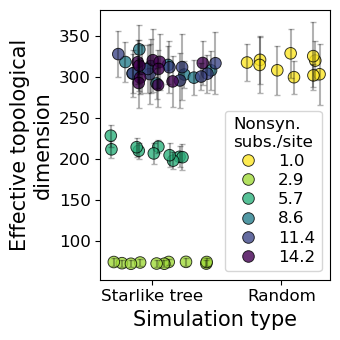

In [ ]:
dfrandstar


df = dfrandstar[dfrandstar['type'].isin(['starlike', 'random_codon'])][['type', 'dim', 'dim_ci', 'number_of_samplings', 'length_scale', 'n_seq_from_dim_log20', 'n_seq_from_dim_log20_ci']]


df['nonsyn_per_site']=(df['number_of_samplings']/300000).round(1)

# map categories to x positions
cats = pd.unique(df['type'])
pos  = {c:i for i, c in enumerate(cats)}
x    = df['type'].map(pos).to_numpy()

# jitter
np.random.seed(3)
xj = x + (np.random.rand(len(x)) - 0.4) * 0.85

fig, ax=plt.subplots(figsize=(3.5,3.5))


ax.errorbar(xj, df['n_seq_from_dim_log20'], yerr=df['n_seq_from_dim_log20_ci'], fmt='none', ecolor='black', capsize=2, alpha=0.3)
sns.scatterplot(x=xj, y=df['n_seq_from_dim_log20'],hue=df['nonsyn_per_site'],
                palette='viridis_r', alpha=0.8,
                s=70, edgecolor='k', ax=ax, legend='full')
ax.legend(title='Nonsyn.\nsubs./site', fontsize=12, title_fontsize=12, labelspacing=0.25)
ax.set_xticks(range(len(cats)), ['Starlike tree', 'Random'])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Simulation type' , size=15)
ax.set_ylabel('Effective topological\ndimension', size=15)
plt.tight_layout()
#plt.savefig('data/allstats/rand_and_starlike_long_evol_x2-10.png', dpi=300)


# Effect of the number of sampled sequences on effective topological dimension. 

Figure S4A

## Load & prepare data

In [8]:
def annotate_significance(ax, x1, x2, y, stars, bar_height=0.05):
    ax.plot([x1, x1, x2, x2], [y, y + bar_height, y + bar_height, y], color='black', linewidth=1)
    ax.text((x1 + x2) / 2, y + bar_height + 0.01, stars, ha='center', va='bottom', fontsize=10)

In [8]:
#load data
substree=pd.read_csv(path+'simu_tree_nseq100_1000_10000_subsampled_from10000_dim_range_from_data.csv')
subsstar=pd.read_csv(path+'simu_tree_starlike_nseq100_1000_10000_subsampled_from10000_dim_range_from_data.csv')
subsrand=pd.read_csv(path+'simu_random_sampling_nseq100_1000_10000_subsampled_from10000_dim_range_from_data.csv')
substree['nseq']=substree['nseq'].astype(int)
subsstar['nseq']=subsstar['nseq'].astype(int)
subsrand['nseq']=subsrand['nseq'].astype(int)
substree['mode']=['tree']*len(substree)
subsstar['mode']=['starlike']*len(subsstar)
subsrand['mode']=['random']*len(subsrand)

In [9]:
nseq_maxdist=pd.read_csv(path+'simu_max_dist_pdistm_matrices_nseqs10000.csv', header=None)
paramsf=[]
paramsrep=[]
types=[]
for i in nseq_maxdist[0]:
    par=re.findall('simu_.+_f(\d.\d+)_nseq\d+_rep(\d+).dist', i)[0]
    paramsf.append(float(par[0]))
    paramsrep.append(int(par[1]))
    if 'random' in i:
        types.append('random')
    elif 'starlike' in i:
        types.append('starlike')
    elif 'tree' in i:
        types.append('tree')
nseq_maxdist=pd.DataFrame({'fraction_allowed_subs':paramsf, 'rep':paramsrep, 'mode':types, 'max_dist':nseq_maxdist[1]})
nseq_maxdist

,fraction_allowed_subs,rep,mode,max_dist
0,0.07,0,random,0.27000
1,0.07,1,random,0.26667
2,0.07,2,random,0.26333
3,0.07,3,random,0.27333
4,0.07,4,random,0.27333
...,...,...,...,...
175,0.35,5,starlike,0.74000
176,0.35,6,starlike,0.75333
177,0.35,7,starlike,0.72667
178,0.35,8,starlike,0.73667


In [11]:
subsrand=subsrand.merge(nseq_maxdist, on=['fraction_allowed_subs', 'rep', 'mode'], how='left')
subsstar=subsstar.merge(nseq_maxdist, on=['fraction_allowed_subs', 'rep', 'mode'], how='left')
substree=substree.merge(nseq_maxdist, on=['fraction_allowed_subs', 'rep', 'mode'], how='left')

In [12]:
#add topological dimension
log_base = np.log10(20)
substree['n_seq_from_dim_log10']= substree['dim']*np.log10((300*substree['max_dist']))
substree['n_seq_from_dim_log20']= substree['n_seq_from_dim_log10'] / np.log10(20)
substree['n_seq_from_dim_log10_ci'] = substree['dim_ci'] * np.log10((300*substree['max_dist']))
substree['n_seq_from_dim_log20_ci'] = substree['n_seq_from_dim_log10_ci']/log_base

subsstar['n_seq_from_dim_log10']= subsstar['dim']*np.log10((300*subsstar['max_dist']))
subsstar['n_seq_from_dim_log20']= subsstar['n_seq_from_dim_log10'] / np.log10(20)
subsstar['n_seq_from_dim_log10_ci'] = subsstar['dim_ci'] * np.log10((300*subsstar['max_dist']))
subsstar['n_seq_from_dim_log20_ci'] = subsstar['n_seq_from_dim_log10_ci']/log_base

subsrand['n_seq_from_dim_log10']= subsrand['dim']*np.log10((300*subsrand['max_dist']))
subsrand['n_seq_from_dim_log20']= subsrand['n_seq_from_dim_log10'] / np.log10(20)
subsrand['n_seq_from_dim_log10_ci'] = subsrand['dim_ci'] * np.log10((300*subsrand['max_dist']))
subsrand['n_seq_from_dim_log20_ci'] = subsrand['n_seq_from_dim_log10_ci']/log_base

## Plot - Figure S4A

Text(0.5, 1.03, 'Effect of sample size (subsampled from 10000 sequences)')

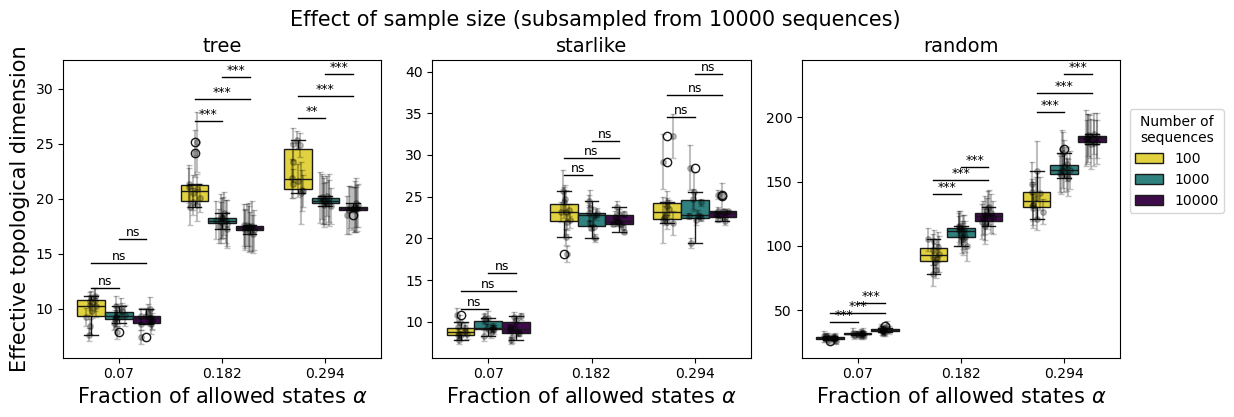

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LogNorm
from itertools import combinations
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for ind, df in enumerate([substree, subsstar, subsrand]):
    ax = axes[ind]
    rnseq = df[df['fraction_allowed_subs'].isin([0.07, 0.182, 0.294])]

    # Plot the boxplot
    box = sns.boxplot(
        data=rnseq,
        x='fraction_allowed_subs',
        y='n_seq_from_dim_log20',
        hue='nseq',
        palette='viridis_r',
        hue_norm=LogNorm(),
        ax=ax
    )

    # Get positions of boxes
    positions = {}
    for patch in ax.artists:
        x, y = patch.get_x(), patch.get_y()
        width = patch.get_width()
        center = x + width / 2
        label = patch.get_label()
        frac_val = round(center)  # approximate base x (0, 1, 2...)
        hue_val = patch.get_facecolor()  # will fix mapping next
        # actual x is center; we build a key for lookup
        positions.setdefault(frac_val, []).append(center)

    # Build a mapping of (fraction_allowed_subs, nseq) → x_pos
    levels_x = sorted(rnseq['fraction_allowed_subs'].unique())
    levels_h = sorted(rnseq['nseq'].unique())
    box_positions = {}  # (x_val, hue_val) -> xpos

    # query xticks and hues to get actual box positions
    xticks = ax.get_xticks()
    for i, xval in enumerate(levels_x):
        n = len(levels_h)
        for j, hval in enumerate(levels_h):
            xpos = xticks[i] - 0.4 + (j + 0.5) * 0.8 / n  # width = 0.8 default
            box_positions[(xval, hval)] = xpos

    # Overlay error bars at correct positions
    for _, row in rnseq.iterrows():
        #x = box_positions[(row['fraction_allowed_subs'], row['nseq'])]
        jitter_strength = 0.06  # adjust this value to control spread
        x = box_positions[(row['fraction_allowed_subs'], row['nseq'])] + np.random.uniform(-jitter_strength, jitter_strength)
        y = row['n_seq_from_dim_log20']
        yerr = row['n_seq_from_dim_log20_ci']
        ax.errorbar(
            x, y,
            yerr=yerr,
            fmt='o',
            markersize=4,
            color='black',
            alpha=0.25,
            capsize=2
        )

    for xval, group in rnseq.groupby('fraction_allowed_subs'):
        unique_nseqs = sorted(group['nseq'].unique())
        comparisons = list(combinations(unique_nseqs, 2))

        # collect p-values for ALL comparisons in this x-group
        pair_keys, pvals = [], []
        for (n1, n2) in comparisons:
            g1 = group[group['nseq'] == n1]['n_seq_from_dim_log20']
            g2 = group[group['nseq'] == n2]['n_seq_from_dim_log20']
            if g1.empty or g2.empty:
                continue
            stat, pval = ttest_ind(g1, g2, equal_var=False)
            pair_keys.append((n1, n2))
            pvals.append(pval)

        reject, pvals_adj, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

        # annotate with adjusted p-values
        y_base = group['n_seq_from_dim_log20'].max() + group['n_seq_from_dim_log20_ci'].max() * 0.7
        if xval==0.07:
            y_step = group['n_seq_from_dim_log20'].max() * 0.2
        else:
            y_step = group['n_seq_from_dim_log20'].max() * 0.08

        for idx, ((n1, n2), padj) in enumerate(zip(pair_keys, pvals_adj)):
            stars = '***' if padj < 1e-3 else '**' if padj < 1e-2 else '*' if padj < 5e-2 else 'ns'
            x1 = box_positions[(xval, n1)]
            x2 = box_positions[(xval, n2)]
            y = y_base + idx * y_step
            ax.plot([x1, x2], [y, y], color='black', linewidth=1)
            ax.text((x1 + x2) / 2, y, stars, ha='center', va='bottom', fontsize=9)

    ax.set_title(rnseq['mode'].iloc[0], fontsize=14)
    ax.set_xlabel(r"Fraction of allowed states $\alpha$", fontsize=15)
    if ind==0:
        ax.set_ylabel("Effective topological dimension", fontsize=15)
    else:
        ax.set_ylabel("")
    ax.legend_.remove()

# Shared legend outside the plot
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Number of\nsequences", bbox_to_anchor=(1.03, 0.8))

fig.tight_layout(rect=[0, 0, 0.95, 1])
fig.suptitle("Effect of sample size (subsampled from 10000 sequences)", fontsize=15, y=1.03)
#plt.tight_layout()


# Dependence of dimensionality on seqeunce length and amino acid usage

Figure S5

## Simulate a grid of all usages (2-20) for lengths: 50, 100, 150, 200, 250, 300

Figure S5A

### Generate data

In [ ]:
usages=range(2,21)
lens=[50, 100, 150, 200, 250, 300]
u220l50300=[]
for lens in tqdm(lens):
    randseq=simevol.generate_nt_seq(lens*3, 1, seqfrom='random', select_from='aa')
    randseqaa=str(Seq(randseq).translate())
    for u in usages:
        for i in range(5):
            lib1000aa=generate_aa_library(randseqaa, list(range(lens)), nseq=1000, usage=u)
            dists=simevol.get_distance_array(lib1000aa)
            dim, dimr2, dimci=seqsp.max_k(dists, win_size_perc=0.5, numbins=20, plot = False,  reg_range_from_data=True, flat=True, ci_r2_out_flat=True)
            u220l50300.append([dim, dimr2, dimci, np.max(dists), np.mean(dists), u, lens])

100%|██████████| 6/6 [1:29:11<00:00, 891.94s/it] 


In [ ]:
dfu220l50300=pd.DataFrame(u220l50300, columns=['dim', 'dim_r^2', 'dim_ci', 'max_dist', 'mean_dist', 'usage', 'length'])
dfu220l50300

,dim,dim_r^2,dim_ci,max_dist,mean_dist,usage,length
0,13.487525,0.958393,1.847582,0.800000,0.499947,2,50
1,11.983969,0.988932,0.833523,0.840000,0.499937,2,50
2,12.307329,0.993156,0.671697,0.800000,0.499897,2,50
3,11.983330,0.980600,1.108144,0.820000,0.499936,2,50
4,12.477517,0.991486,0.760184,0.820000,0.500102,2,50
...,...,...,...,...,...,...,...
565,167.243109,0.976163,17.182163,1.000000,0.949996,20,300
566,172.909014,0.984418,14.302296,0.996667,0.949987,20,300
567,170.478340,0.984479,14.073205,0.996667,0.950039,20,300
568,192.704256,0.985900,15.151083,0.996667,0.950011,20,300


In [ ]:
dfu220l50300['n_seq_from_dim_log10']=  dfu220l50300['dim']*np.log10(dfu220l50300['length'])
dfu220l50300['n_seq_from_dim_log20'] = dfu220l50300['n_seq_from_dim_log10'] / np.log10(20)
dfu220l50300['n_seq_from_dim_log_alpha'] = dfu220l50300['n_seq_from_dim_log10'] / np.log10(dfu220l50300['usage'])
dfu220l50300['n_seq_from_dim_log10_ci']=  dfu220l50300['dim_ci']*np.log10(dfu220l50300['length'])
dfu220l50300['n_seq_from_dim_log20_ci'] = dfu220l50300['n_seq_from_dim_log10_ci'] / np.log10(20)
dfu220l50300['n_seq_from_dim_log_alpha_ci'] = dfu220l50300['n_seq_from_dim_log10_ci'] / np.log10(dfu220l50300['usage'])
dfu220l50300

,dim,dim_r^2,dim_ci,max_dist,mean_dist,usage,length,n_seq_from_dim_log10,n_seq_from_dim_log20,n_seq_from_dim_log_alpha,n_seq_from_dim_log10_ci,n_seq_from_dim_log20_ci,n_seq_from_dim_log_alpha_ci
0,13.487525,0.958393,1.847582,0.800000,0.499947,2,50,22.914900,17.612892,76.121652,3.138986,2.412693,10.427486
1,11.983969,0.988932,0.833523,0.840000,0.499937,2,50,20.360403,15.649450,67.635796,1.416130,1.088469,4.704283
2,12.307329,0.993156,0.671697,0.800000,0.499897,2,50,20.909784,16.071715,69.460797,1.141193,0.877146,3.790962
3,11.983330,0.980600,1.108144,0.820000,0.499936,2,50,20.359319,15.648616,67.632194,1.882704,1.447087,6.254207
4,12.477517,0.991486,0.760184,0.820000,0.500102,2,50,21.198927,16.293957,70.421310,1.291529,0.992697,4.290366
...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,167.243109,0.976163,17.182163,1.000000,0.949996,20,300,414.281461,318.425757,318.425757,42.562301,32.714312,32.714312
566,172.909014,0.984418,14.302296,0.996667,0.949987,20,300,428.316595,329.213466,329.213466,35.428521,27.231133,27.231133
567,170.478340,0.984479,14.073205,0.996667,0.950039,20,300,422.295520,324.585537,324.585537,34.861035,26.794951,26.794951
568,192.704256,0.985900,15.151083,0.996667,0.950011,20,300,477.351810,366.903001,366.903001,37.531070,28.847198,28.847198


In [ ]:
usages=range(2,21)
lens=[350,400,450,500]
u220l300500=[]
for lens in tqdm(lens):
    randseq=simevol.generate_nt_seq(lens*3, 1, seqfrom='random', select_from='aa')
    randseqaa=str(Seq(randseq).translate())
    for u in usages:
        for i in range(5):
            lib1000aa=generate_aa_library(randseqaa, list(range(lens)), nseq=1000, usage=u)
            dists=simevol.get_distance_array(lib1000aa)
            dim, dimr2, dimci=seqsp.max_k(dists, win_size_perc=0.5, numbins=20, plot = False,  reg_range_from_data=True, flat=True, ci_r2_out_flat=True)
            u220l300500.append([dim, dimr2, dimci, np.max(dists), np.mean(dists), u, lens])

100%|██████████| 4/4 [2:08:19<00:00, 1924.83s/it]  


In [ ]:
dfu220l300500=pd.DataFrame(u220l300500, columns=['dim', 'dim_r^2', 'dim_ci', 'max_dist', 'mean_dist', 'usage', 'length'])
dfu220l300500

,dim,dim_r^2,dim_ci,max_dist,mean_dist,usage,length
0,42.093517,0.960580,5.606181,0.625714,0.500019,2,350
1,40.796291,0.966284,5.010163,0.622857,0.499965,2,350
2,41.479940,0.969416,4.843896,0.631429,0.499985,2,350
3,40.973993,0.969593,4.770489,0.625714,0.499986,2,350
4,40.492746,0.979954,3.807574,0.620000,0.500007,2,350
...,...,...,...,...,...,...,...
375,239.167030,0.969085,28.084699,0.992000,0.950004,20,500
376,224.613506,0.979604,21.308278,0.986000,0.949982,20,500
377,234.643393,0.976567,23.896589,0.992000,0.950002,20,500
378,211.350700,0.984072,17.678280,0.990000,0.949994,20,500


In [ ]:
dfu220l300500['n_seq_from_dim_log10']=  dfu220l300500['dim']*np.log10(dfu220l300500['length'])
dfu220l300500['n_seq_from_dim_log20'] = dfu220l300500['n_seq_from_dim_log10'] / np.log10(20)
dfu220l300500['n_seq_from_dim_log_alpha'] = dfu220l300500['n_seq_from_dim_log10'] / np.log10(dfu220l300500['usage'])
dfu220l300500['n_seq_from_dim_log10_ci']=  dfu220l300500['dim_ci']*np.log10(dfu220l300500['length'])
dfu220l300500['n_seq_from_dim_log20_ci'] = dfu220l300500['n_seq_from_dim_log10_ci'] / np.log10(20)
dfu220l300500['n_seq_from_dim_log_alpha_ci'] = dfu220l300500['n_seq_from_dim_log10_ci'] / np.log10(dfu220l300500['usage'])
dfu220l300500

,dim,dim_r^2,dim_ci,max_dist,mean_dist,usage,length,n_seq_from_dim_log10,n_seq_from_dim_log20,n_seq_from_dim_log_alpha,n_seq_from_dim_log10_ci,n_seq_from_dim_log20_ci,n_seq_from_dim_log_alpha_ci
0,42.093517,0.960580,5.606181,0.625714,0.500019,2,350,107.088772,82.310763,355.741200,14.262507,10.962474,47.379023
1,40.796291,0.966284,5.010163,0.622857,0.499965,2,350,103.788541,79.774133,344.778069,12.746196,9.797004,42.341945
2,41.479940,0.969416,4.843896,0.631429,0.499985,2,350,105.527790,81.110958,350.555729,12.323200,9.471880,40.936786
3,40.973993,0.969593,4.770489,0.625714,0.499986,2,350,104.240625,80.121616,346.279862,12.136448,9.328339,40.316409
4,40.492746,0.979954,3.807574,0.620000,0.500007,2,350,103.016300,79.180573,342.212741,9.686727,7.445429,32.178611
...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,239.167030,0.969085,28.084699,0.992000,0.950004,20,500,645.504640,496.148930,496.148930,75.799760,58.261347,58.261347
376,224.613506,0.979604,21.308278,0.986000,0.949982,20,500,606.225115,465.957831,465.957831,57.510403,44.203749,44.203749
377,234.643393,0.976567,23.896589,0.992000,0.950002,20,500,633.295478,486.764702,486.764702,64.496177,49.573167,49.573167
378,211.350700,0.984072,17.678280,0.990000,0.949994,20,500,570.429200,438.444311,438.444311,47.713148,36.673365,36.673365


In [ ]:
dfu220l50500=pd.concat([dfu220l50300, dfu220l300500], ignore_index=True)
dfu220l50500.to_csv(path+'random_seq_dim_length50-500_usage2-20_map.csv', index=False)

### Plot - Figure S5A

In [10]:
dfu220l50500=pd.read_csv(path+'random_seq_dim_length50-500_usage2-20_map.csv')

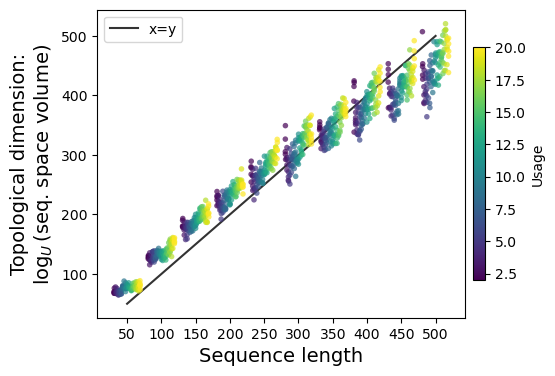

In [ ]:
import matplotlib as mpl

ax = sns.stripplot(
    data=dfu220l50500, x='length', y='n_seq_from_dim_log_alpha',
    hue='usage', palette='viridis', dodge=True, edgecolor='k', size=4, alpha=0.7, legend=False
)

plt.plot(ax.get_xticks(), sorted(set(dfu220l50500['length'])),
         color='k', alpha=0.8, label='x=y')
plt.legend()
plt.ylabel('Topological dimension:\n' + r"$\log_{U}$(seq. space volume)", size=14)
plt.xlabel('Sequence length', size=14)

# --- colorbar (simple) ---
norm = mpl.colors.Normalize(vmin=2, vmax=20)  # or dfu220l50500['usage'].min()/max()
sm = mpl.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])

ax.figure.colorbar(sm, ax=ax, label="Usage", fraction=0.03, pad=0.02)
ax.figure.set_size_inches(5, 4) 

## Simulate a grid of all usages (2-20) for lengths in range 2-15

Figure S5B

### Generate data

In [ ]:
usages=range(2,21)
lens=range(2,16)
u220l215=[]
for lens in tqdm(lens):
    randseq=simevol.generate_nt_seq(lens*3, 1, seqfrom='random', select_from='aa')
    randseqaa=str(Seq(randseq).translate())
    for u in usages:
        for i in range(5):
            lib1000aa=generate_aa_library(randseqaa, list(range(lens)), nseq=1000, usage=u)
            dists=simevol.get_distance_array(lib1000aa)
            dim, dimr2, dimci=seqsp.max_k(dists, win_size_perc=0.5, numbins=20, plot = False,  reg_range_from_data=True, flat=True, ci_r2_out_flat=True)
            u220l215.append([dim, dimr2, dimci, np.max(dists), np.mean(dists), u, lens])

100%|██████████| 14/14 [08:30<00:00, 36.49s/it]


In [ ]:
dfu220l215=pd.DataFrame(u220l215, columns=['dim', 'dim_r^2', 'dim_ci', 'max_dist', 'mean_dist', 'usage', 'length'])
dfu220l215

,dim,dim_r^2,dim_ci,max_dist,mean_dist,usage,length
0,1.782913,0.753104,0.671154,1.0,0.499616,2,2
1,1.788406,0.753104,0.673222,1.0,0.500282,2,2
2,1.784236,0.753104,0.671653,1.0,0.499122,2,2
3,1.787041,0.753104,0.672708,1.0,0.500160,2,2
4,1.785800,0.753104,0.672241,1.0,0.500450,2,2
...,...,...,...,...,...,...,...
1325,23.370420,0.938300,3.940030,1.0,0.949979,20,15
1326,23.190533,0.933785,4.060012,1.0,0.950079,20,15
1327,25.363141,0.956161,3.570501,1.0,0.949973,20,15
1328,28.264819,0.950243,4.252267,1.0,0.950054,20,15


In [ ]:
dfu220l215['n_seq_from_dim_log10']=  dfu220l215['dim']*np.log10(dfu220l215['length'])
dfu220l215['n_seq_from_dim_log20'] = dfu220l215['n_seq_from_dim_log10'] / np.log10(20)
dfu220l215['n_seq_from_dim_log_alpha'] = dfu220l215['n_seq_from_dim_log10'] / np.log10(dfu220l215['usage'])
dfu220l215['n_seq_from_dim_log10_ci']=  dfu220l215['dim_ci']*np.log10(dfu220l215['length'])
dfu220l215['n_seq_from_dim_log20_ci'] = dfu220l215['n_seq_from_dim_log10_ci'] / np.log10(20)
dfu220l215['n_seq_from_dim_log_alpha_ci'] = dfu220l215['n_seq_from_dim_log10_ci'] / np.log10(dfu220l215['usage'])
dfu220l215

,dim,dim_r^2,dim_ci,max_dist,mean_dist,usage,length,n_seq_from_dim_log10,n_seq_from_dim_log20,n_seq_from_dim_log_alpha,n_seq_from_dim_log10_ci,n_seq_from_dim_log20_ci,n_seq_from_dim_log_alpha_ci
0,1.782913,0.753104,0.671154,1.0,0.499616,2,2,0.536710,0.412527,1.782913,0.202038,0.155291,0.671154
1,1.788406,0.753104,0.673222,1.0,0.500282,2,2,0.538364,0.413798,1.788406,0.202660,0.155769,0.673222
2,1.784236,0.753104,0.671653,1.0,0.499122,2,2,0.537109,0.412833,1.784236,0.202188,0.155406,0.671653
3,1.787041,0.753104,0.672708,1.0,0.500160,2,2,0.537953,0.413482,1.787041,0.202505,0.155650,0.672708
4,1.785800,0.753104,0.672241,1.0,0.500450,2,2,0.537579,0.413195,1.785800,0.202365,0.155542,0.672241
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325,23.370420,0.938300,3.940030,1.0,0.949979,20,15,27.485746,21.126143,21.126143,4.633835,3.561667,3.561667
1326,23.190533,0.933785,4.060012,1.0,0.950079,20,15,27.274184,20.963532,20.963532,4.774944,3.670126,3.670126
1327,25.363141,0.956161,3.570501,1.0,0.949973,20,15,29.829369,22.927503,22.927503,4.199235,3.227624,3.227624
1328,28.264819,0.950243,4.252267,1.0,0.950054,20,15,33.242006,25.550530,25.550530,5.001054,3.843919,3.843919


In [ ]:
dfu220l215.to_csv(path+'random_seq_dim_length2-15_usage2-20_map.csv', index=False)

### Plot - Figure S5B

In [11]:
dfu220l215=pd.read_csv(path+'random_seq_dim_length2-15_usage2-20_map.csv')

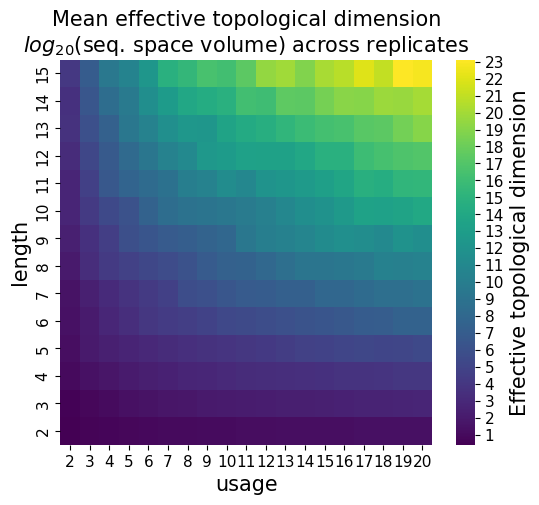

In [32]:
df_grid = (
    dfu220l215
    .groupby(["usage", "length"], as_index=False)
    ["n_seq_from_dim_log20"]
    .mean()
)

grid = df_grid.pivot(index="length", columns="usage", values="n_seq_from_dim_log20")
plt.figure(figsize=(6,5))
ax=sns.heatmap(grid, cmap="viridis", cbar_kws={"label": r"$log_{20}$(number of sequences)"})
cbar = ax.collections[0].colorbar
vmin, vmax = cbar.vmin, cbar.vmax
ticks = np.arange(np.ceil(vmin), np.floor(vmax) + 1)

cbar.set_ticks(ticks)

# 2. Increase tick label size
cbar.ax.tick_params(labelsize=11)
cbar.ax.set_ylabel("Effective topological dimension", fontsize=15)
plt.xlabel("usage", size=15)
plt.ylabel("length", size=15)
plt.title("Mean effective topological dimension\n"+r"$log_{20}$(seq. space volume) across replicates", size=15)
plt.tick_params(axis='both', which='major', labelsize=11)
plt.gca().invert_yaxis()
plt.show()